This notebook is an analytic project into a New York Airbnb dataset, which comprises of listings, descriptions and review scores, prices, availability, etc. Data can be found at this link: https://www.kaggle.com/datasets/arianazmoudeh/airbnbopendata

To clearly document my method:
1. We will start with importing the dataset and cleaning the values in preparation for analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
import seaborn as sns

#for maps
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import matplotlib.cm as cm

import warnings
warnings.filterwarnings('ignore')

Loading the CSV into a pandas Dataframe.


In [2]:
df = pd.read_csv(("airbnb.csv"), low_memory=False)

In [3]:
df.head()

,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,$74,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,$41,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


A little more basic exploration of the data...


In [4]:
df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              102599 non-null  int64  
 1   NAME                            102349 non-null  object 
 2   host id                         102599 non-null  int64  
 3   host_identity_verified          102310 non-null  object 
 4   host name                       102193 non-null  object 
 5   neighbourhood group             102570 non-null  object 
 6   neighbourhood                   102583 non-null  object 
 7   lat                             102591 non-null  float64
 8   long                            102591 non-null  float64
 9   country                         102067 non-null  object 
 10  country code                    102468 non-null  object 
 11  instant_bookable                102494 non-null  object 
 12  cancellation_pol

,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
102594,6092437,Spare room in Williamsburg,12312296767,verified,Krik,Brooklyn,Williamsburg,40.70862,-73.94651,United States,...,$169,1.0,0.0,NaN,NaN,3.0,1.0,227.0,No Smoking No Parties or Events of any kind Pl...,NaN
102595,6092990,Best Location near Columbia U,77864383453,unconfirmed,Mifan,Manhattan,Morningside Heights,40.80460,-73.96545,United States,...,$167,1.0,1.0,7/6/2015,0.02,2.0,2.0,395.0,House rules: Guests agree to the following ter...,NaN
102596,6093542,"Comfy, bright room in Brooklyn",69050334417,unconfirmed,Megan,Brooklyn,Park Slope,40.67505,-73.98045,United States,...,$198,3.0,0.0,NaN,NaN,5.0,1.0,342.0,NaN,NaN
102597,6094094,Big Studio-One Stop from Midtown,11160591270,unconfirmed,Christopher,Queens,Long Island City,40.74989,-73.93777,United States,...,$109,2.0,5.0,10/11/2015,0.10,3.0,1.0,386.0,NaN,NaN
102598,6094647,585 sf Luxury Studio,68170633372,unconfirmed,Rebecca,Manhattan,Upper West Side,40.76807,-73.98342,United States,...,$206,1.0,0.0,NaN,NaN,3.0,1.0,69.0,NaN,NaN


There are several glaring issues that we will take care of. First of all, I'm going to rename several of the columns to their snake_case variant for legibility and consistency's sake.


In [5]:
df = df.rename(columns={
    'NAME': 'name',
    'host id': 'host_id',
    'host name': 'host_name',
    'neighbourhood group': 'borough', #since the entire dataset is in NYC, I thought I would make this column a little more specific
    'neighbourhood': 'neighborhood', #american spelling
    'country code': 'country_code',
    'room type': 'room_type',
    'Construction year': 'construction_year',
    'service fee': 'service_fee',
    'minimum nights': 'minimum_nights',
    'number of reviews': 'number_of_reviews',
    'last review': 'last_review',
    'reviews per month': 'reviews_per_month',
    'review rate number': 'review_rate_number',
    'calculated host listings count': 'calculated_host_listings_count',
    'availability 365': 'availability_365',
})
df.head()

,id,name,host_id,host_identity_verified,host_name,borough,neighborhood,lat,long,country,...,service_fee,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,$74,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,$41,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


Next, we'll get rid of irrelevant columns. From an analytics perspective, columns like `id`, `host_id`, `host_name`, etc. aren't useful in visualization or regression. They can be dropped.
Columns like `license` have just two non-null values and can easily be dropped too.

In [6]:
df.drop(columns=['id', 'host_id', 'country_code', 'license', 'house_rules', 'number_of_reviews', 'name', 'country', 'last_review'], inplace=True)

In [7]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   host_identity_verified          102310 non-null  object 
 1   host_name                       102193 non-null  object 
 2   borough                         102570 non-null  object 
 3   neighborhood                    102583 non-null  object 
 4   lat                             102591 non-null  float64
 5   long                            102591 non-null  float64
 6   instant_bookable                102494 non-null  object 
 7   cancellation_policy             102523 non-null  object 
 8   room_type                       102599 non-null  object 
 9   construction_year               102385 non-null  float64
 10  price                           102352 non-null  object 
 11  service_fee                     102326 non-null  object 
 12  minimum_nights  

,host_identity_verified,host_name,borough,neighborhood,lat,long,instant_bookable,cancellation_policy,room_type,construction_year,price,service_fee,minimum_nights,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365
0,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,False,strict,Private room,2020.0,$966,$193,10.0,0.21,4.0,6.0,286.0
1,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,False,moderate,Entire home/apt,2007.0,$142,$28,30.0,0.38,4.0,2.0,228.0
2,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,True,flexible,Private room,2005.0,$620,$124,3.0,NaN,5.0,1.0,352.0
3,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,True,moderate,Entire home/apt,2005.0,$368,$74,30.0,4.64,4.0,1.0,322.0
4,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,False,moderate,Entire home/apt,2009.0,$204,$41,10.0,0.10,3.0,1.0,289.0


Let's get rid of all duplicate values, in addition to handling the missing values of each column.

In [8]:
#dropping all duplicates
df.drop_duplicates(inplace=True)

#filling missing values for each column
missing_values = {
  'host_identity_verified' : 'unconfirmed',
  'host_name' : 'Unknown',
  'borough' : 'Unknown',
  'neighborhood' : 'Unknown',
  'lat' : 0.0,
  'long' : 0.0,
  'instant_bookable' : False,
  'cancellation_policy' : 'Unknown',
  'construction_year' : 0,
  'service_fee' : 0.0,
  'minimum_nights' : 0.0,
  'reviews_per_month' : 0,
  'review_rate_number' : 0,
  'calculated_host_listings_count' : 0,
  'availability_365' : 0,
  'price' : 0.0
}
df.fillna(value=missing_values, inplace=True)


Let's clean the price values and the room_type. `price` and `service_fee` will no longer have $'s and `room_type` will be a simpler string. There are some mispellings in the `boroughs` that we will correct too.


In [9]:
#converting price and service fee into floats; getting rid of $

#trimming for spaces
df['price'] = df['price'].str.strip()
df['service_fee'] = df['service_fee'].str.strip()

#deleting commas (to eventually convert into float)
df['price'] = df['price'].str.replace(',', '', regex=False)
df['service_fee'] = df['service_fee'].str.replace(',', '', regex=False)

#deleting $ and converting to float
df['price'] = df['price'].str.replace('$', '', regex=False).astype(float)
df['service_fee'] = df['service_fee'].str.replace('$', '', regex=False).astype(float)

#converting the room_type column to a simpler string
room_type_changes = {
    'Private room': 'private',
    'Entire home/apt': 'entirehome',
    'Shared room': 'shared',
    'Hotel room': 'hotelroom'
}

# Replace the entries in the room_type column
df['room_type'] = df['room_type'].replace(room_type_changes)

#converting boroughs spelled "brookln" or "manhatan" to their proper category
borough_changes = {
    'brookln': 'Brooklyn',
    'manhatan': 'Manhattan'
}
df['borough'] = df['borough'].replace(borough_changes)

missing_values_price_service_fee = {
    'price' : 0.0,
    'service_fee' : 0.0
}
df.fillna(value=missing_values_price_service_fee, inplace=True)

We have to reinitialize the null values for price and service fee because they changed.

In [10]:
df.head()
missing_values_price_service_fee = {
    'price' : 0.0,
    'service_fee' : 0.0
}
df.fillna(value=missing_values_price_service_fee, inplace=True)

In [11]:
print(df.isnull().sum())

host_identity_verified            0
host_name                         0
borough                           0
neighborhood                      0
lat                               0
long                              0
instant_bookable                  0
cancellation_policy               0
room_type                         0
construction_year                 0
price                             0
service_fee                       0
minimum_nights                    0
reviews_per_month                 0
review_rate_number                0
calculated_host_listings_count    0
availability_365                  0
dtype: int64


We've cleared the dataset of null values! Onto the visualization part now.

## Data Analysis + Visualizations

Let's start simple; I'm going to create a simple count plot to see which type of room is most prevalently available in the data.

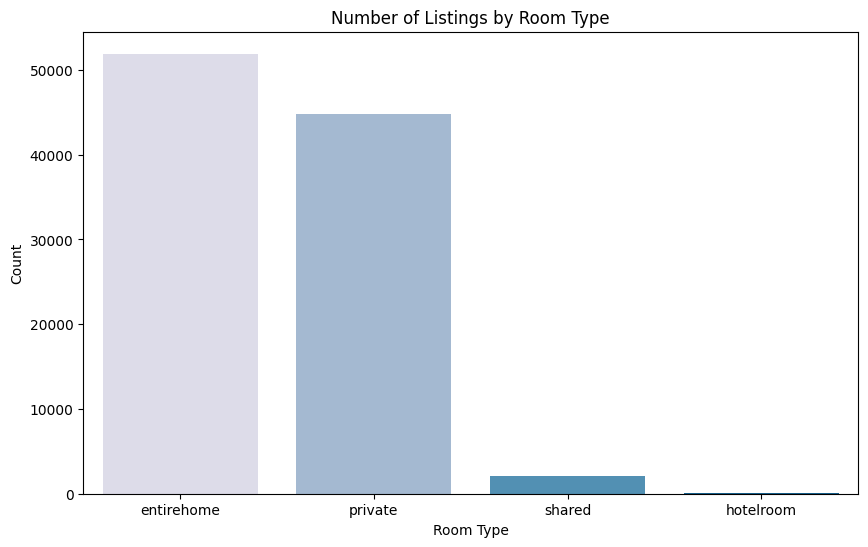

In [12]:
# basic count plot
order = df['room_type'].value_counts().index
plt.figure(figsize=(10, 6))
sns.countplot(x='room_type', data=df, order = order, palette='PuBu')
plt.title('Number of Listings by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Count')
plt.show()


Next, let's create a scatterplot map based on the `long` and `lat`. The points will be plotted on a graph, with a basemap of NYC underneath for easier viewing experience. A color bar, ranging from white to dark blue, indicates the price of the listing.

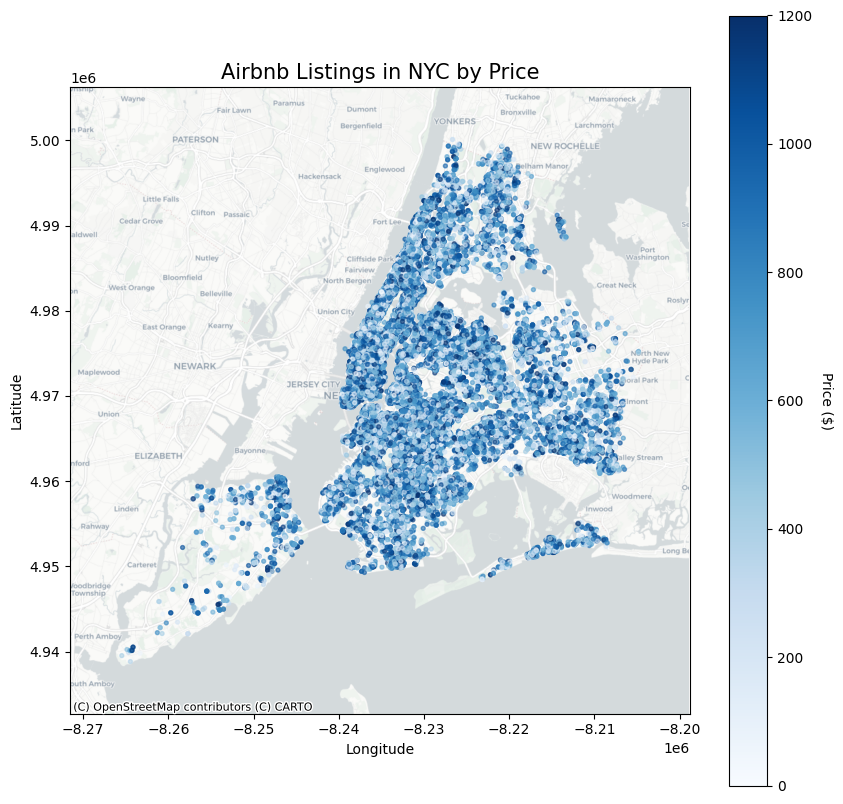

In [13]:
nyc_df = df[(df['lat'] != 0) & (df['long'] != 0)]

#convert to gdf
gdf = gpd.GeoDataFrame(nyc_df, geometry=gpd.points_from_xy(nyc_df['long'], nyc_df['lat']))

#geopandas setting to mercator projection
gdf = gdf.set_crs(epsg=4326)
gdf = gdf.to_crs(epsg=3857)


norm_price = (gdf['price'] - gdf['price'].min()) / (gdf['price'].max() - gdf['price'].min())

# Create a color map (range of blue colors)
cmap = cm.get_cmap('Blues')

# Data points normalized to the color map
colors = cmap(norm_price)

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, markersize=8, color=colors, alpha=0.6, edgecolor=None)



# Add a map for NYC using contextily
ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.CartoDB.Positron)

minx, miny, maxx, maxy = gdf.total_bounds

# Padding so that the map looks nice
x_pad = (maxx - minx) * 0.1
y_pad = (maxy - miny) * 0.1

#setting map limits
ax.set_xlim(minx - x_pad, maxx + x_pad)
ax.set_ylim(miny - y_pad, maxy + y_pad)

#labels and titles
ax.set_title('Airbnb Listings in NYC by Price', fontsize=15)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

#creating the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=df['price'].min(), vmax=df['price'].max()))
sm.set_array([])  #no warnings
cbar = plt.colorbar(sm)
cbar.set_label('Price ($)', rotation=270, labelpad=15)

# Show the plot
plt.show()


This is a very interesting map! We can see that Lower Manhattan is completely covered in listings, which shows the density and popularity of the area.

Let's try something else. Let's try the same principle of plotting the points on the overlay of NYC, but this time let's change it so that the points reflect the type of room they have: the entire house, private rooms, shared rooms, or hotel rooms.

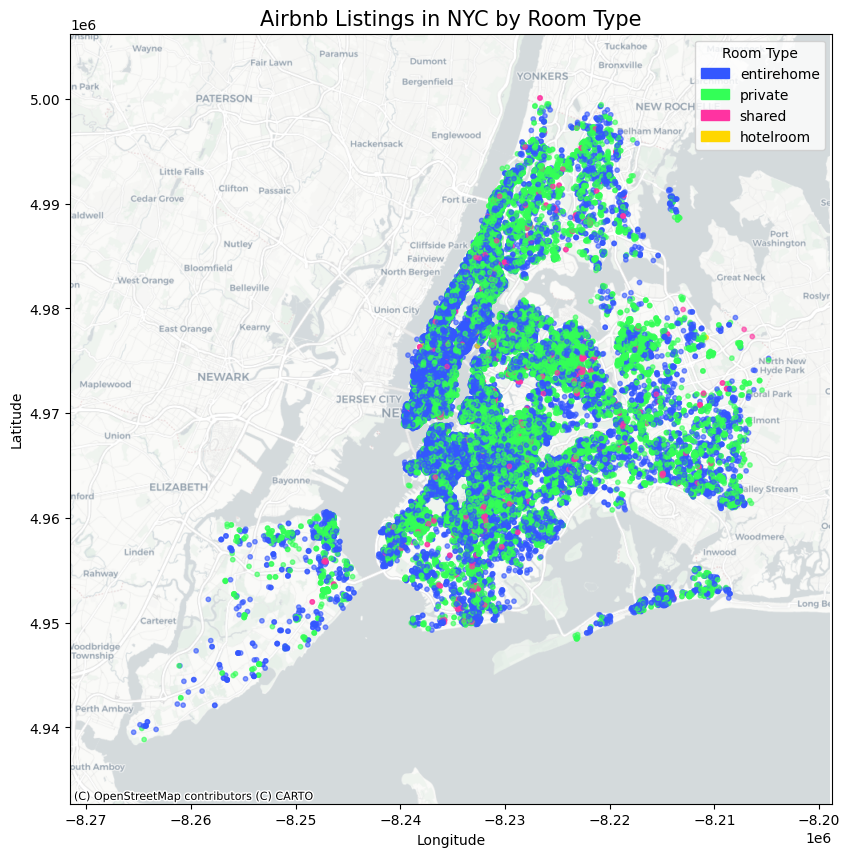

In [14]:
# nyc_df should be initialized already.
gdf1 = gpd.GeoDataFrame(nyc_df, geometry=gpd.points_from_xy(nyc_df['long'], nyc_df['lat']))

#coordinate ref + mercator
gdf1 = gdf.set_crs(epsg=4326, allow_override = True)
gdf1 = gdf.to_crs(epsg=3857)


room_colors = {
    'entirehome': '#3357FF',
    'private': '#33FF57',
    'shared': '#FF33A1',
    'hotelroom': '#FFD700'
}

# mapping rooms to colors
gdf1['color'] = gdf1['room_type'].map(room_colors)

# Plotting points
fig, ax = plt.subplots(figsize=(10, 10))

#plotting points
gdf1.plot(ax=ax, markersize=10, color=gdf1['color'], alpha=0.6, edgecolor=None)

# basemap using contextily
ctx.add_basemap(ax, crs=gdf1.crs, source=ctx.providers.CartoDB.Positron)


minx_2, miny_2, maxx_2, maxy_2 = gdf.total_bounds


x_pad1 = (maxx_2 - minx_2) * 0.1  #padding for better viewing
y_pad1 = (maxy_2 - miny_2) * 0.1


ax.set_xlim(minx_2 - x_pad1, maxx_2 + x_pad1)
ax.set_ylim(miny_2 - y_pad1, maxy_2 + y_pad1)

# labels and title
ax.set_title('Airbnb Listings in NYC by Room Type', fontsize=15)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# creating the legend
handles = [mpatches.Patch(color=color, label=room) for room, color in room_colors.items()]
ax.legend(handles=handles, title='Room Type')

plt.show()


It seems like the primary concentration of entire home/apartment listings are centered around Manhattan. As we can see, the further we get into more residential areas like the Bronx and Queens, the concentration of private rooms definitely increases.

Let's answer some particular questions about this dataset:
How does the type of room affect the price?


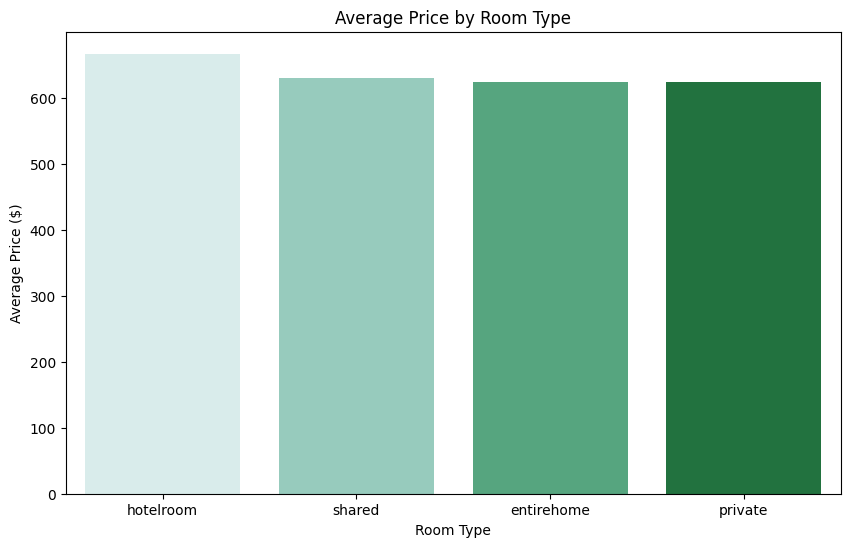

In [15]:
# Calculate average prices per room type
average_price = df.groupby('room_type')['price'].mean().reset_index()
average_price = average_price.sort_values(by='price', ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='room_type', y='price', data=average_price, palette='BuGn')
plt.title('Average Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Price ($)')
plt.show()


Suprisingly, the three major categories of `room_type` are relatively similar in pricing. `hotelroom` is high, but this could be attributed to the extremely low sample size.

Which 10 neighborhoods are, on average, the most expensive to stay at?

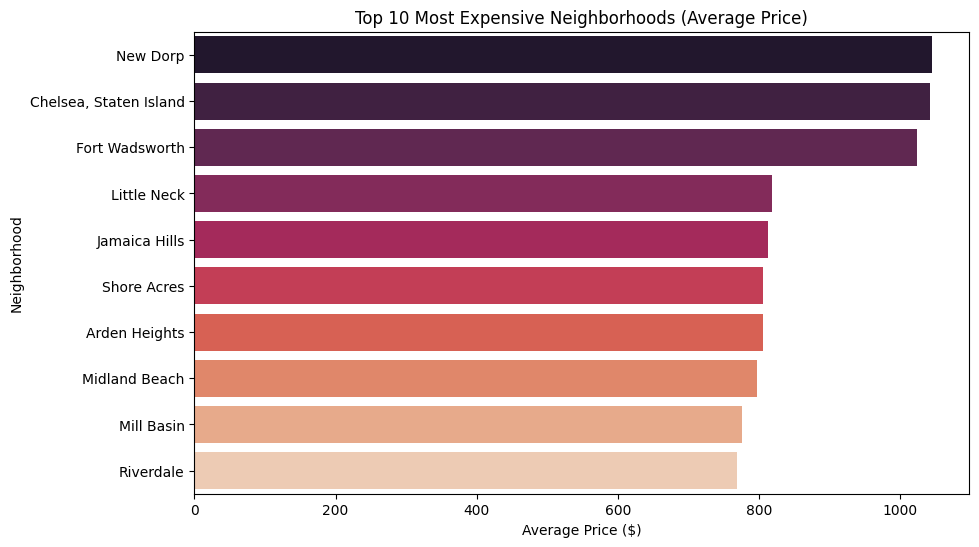

In [16]:
average_price_per_neighborhood = df.groupby('neighborhood')['price'].mean().reset_index()

# Sort by average price in descending order and get the top 10 neighborhoods
top_10_neighborhoods = average_price_per_neighborhood.sort_values(by='price', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='price', y='neighborhood', data=top_10_neighborhoods, palette='rocket')
plt.title('Top 10 Most Expensive Neighborhoods (Average Price)')
plt.xlabel('Average Price ($)')
plt.ylabel('Neighborhood')
plt.show()


Interestingly, the top 3 most expensive neighborhoods by average price are all in Staten Island. However, there is considerably less data in the Staten Island borough than any of the other boroughs. More data in the area would be necessary to achieve a more reliable average. So let's redo it, but this time, it has to be a neighborhood with at least 30 listings.


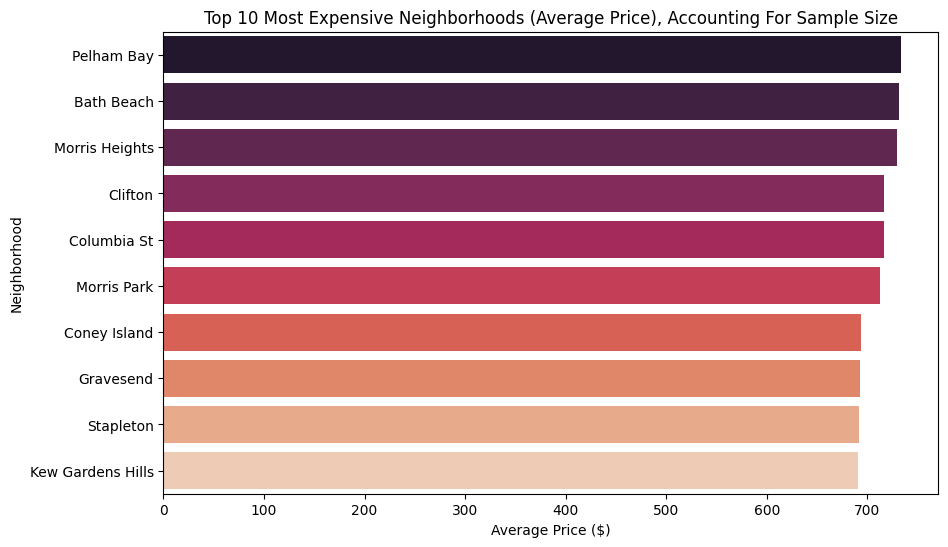

In [17]:
average_price_per_neighborhood = df.groupby('neighborhood')['price'].mean().reset_index()

neighborhood_df = df['neighborhood'].value_counts().reset_index()
neighborhood_df.columns = ['neighborhood', 'count']

merged_data = pd.merge(average_price_per_neighborhood, neighborhood_df, on='neighborhood')

filtered_neighborhoods = merged_data[merged_data['count'] >= 30]

# Sort by average price in descending order and get the top 10 neighborhoods
top_10_neighborhoods = filtered_neighborhoods.sort_values(by='price', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='price', y='neighborhood', data=top_10_neighborhoods, palette='rocket')
plt.title('Top 10 Most Expensive Neighborhoods (Average Price), Accounting For Sample Size')
plt.xlabel('Average Price ($)')
plt.ylabel('Neighborhood')
plt.show()

This visual provides a much more accurate representation of the most expensive neighborhoods. It also makes more sense intuitively; the neighborhoods around a tourist attraction like Coney Island (such as Bath Beach and Gravesend) would be amongst the most expensive. Somewhat surprisingly is an absence of Manhattan neighborhoods.

Let's take a look at the Cancellation Policy real quick. As a reminder, there are 3 ranks to the cancellation: strict, moderate, and flexible. Let's see how those policies affect the price of the listing.

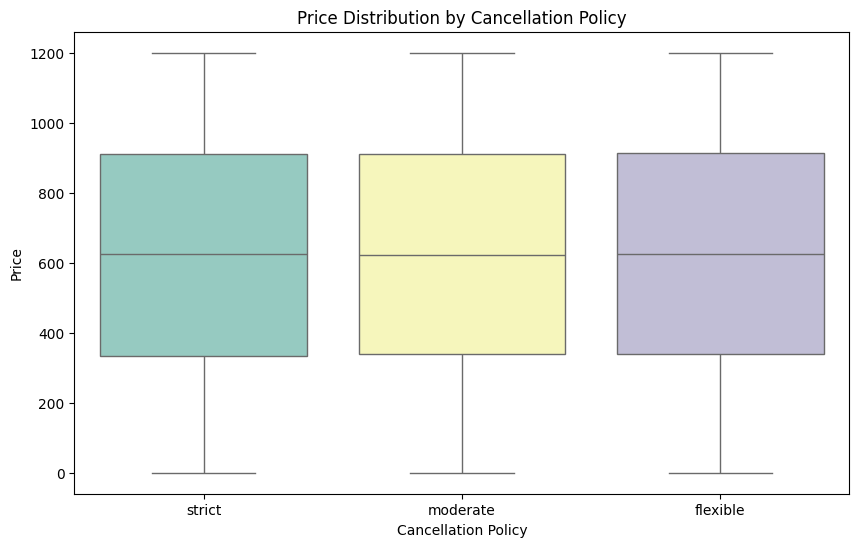

In [18]:

df_filtered = df[df['cancellation_policy'] != 'Unknown']

plt.figure(figsize=(10, 6))
sns.boxplot(x='cancellation_policy', y='price', data=df_filtered, palette='Set3')
plt.title('Price Distribution by Cancellation Policy')
plt.xlabel('Cancellation Policy')
plt.ylabel('Price')
plt.show()



We can see in this box plot, that there is almost no variation in the price when grouping for cancellation policy.

Let's now see which neighborhood's listings, on average, are most available to be stayed in. Again, we'll use the 30 minimum amount of listings to be eligible to avoid outliers.


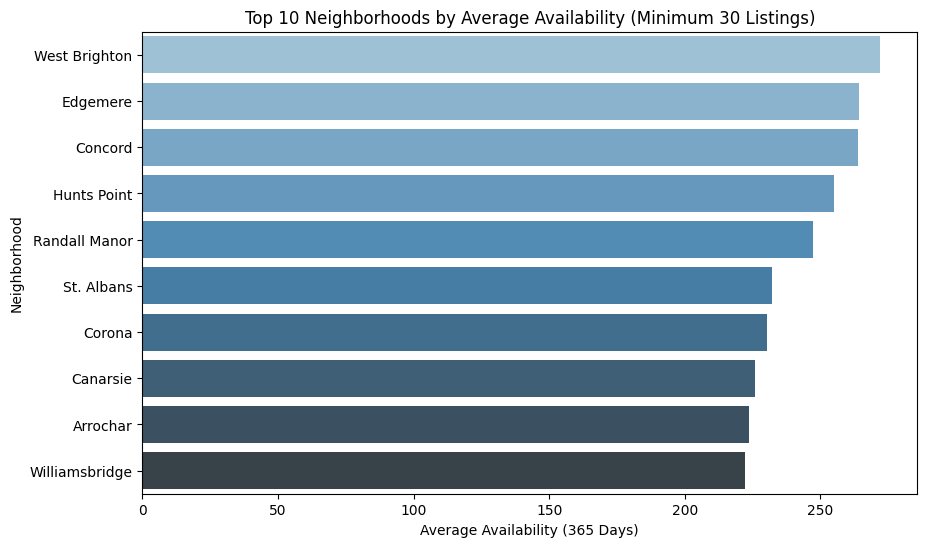

In [19]:
neighborhood_availability = df.groupby('neighborhood')['availability_365'].agg(['mean', 'count']).reset_index()

eligible_neighborhoods = neighborhood_availability[neighborhood_availability['count'] >= 30]


sorted_neighborhoods = eligible_neighborhoods.sort_values(by='mean', ascending=False)

top_10_neighborhoods = sorted_neighborhoods.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='mean', y='neighborhood', data=top_10_neighborhoods, palette='Blues_d')
plt.title('Top 10 Neighborhoods by Average Availability (Minimum 30 Listings)')
plt.xlabel('Average Availability (365 Days)')
plt.ylabel('Neighborhood')
plt.show()

Many of these neighborhoods are in Staten Island, Queens and the Bronx, far from the big city. This makes sense, because people typically go to New York to experience the tourist spots like Manhattan, resulting in less overall interest in places far from Manhattan, and thus a higher average availability.

## Findings
To summarize some of the findings within this dataset:
- Although very different, private rooms, shared rooms, and entire apartments/houses have extremely similar means.
- Listings for entire apartments, according to the map, seem to be concentrated around Manhattan, while private rooms are more prevalent in residential areas.
- There are many more entire home listings than private rooms or shared rooms in NYC Airbnb.
- The most expensive neighborhoods to stay at, adjusted for sample size and outliers, are targeted around major hubs and tourist attractions.
- There is virtually no difference in price when accounting for cancellation policies.
- Certain neighborhoods in largely residential areas (primarily Staten Island and Queens) are the most readily available (vacant) properties on the market.